# Clustering de instituciones de los estados unidos

En este notebook se realiza un agrupamiento de instituciones para identificar fortalezas y debilidades de estas con un conjunto de datos previamente formateados exclusivamente para este estudio.

## Objetivos

- Identificar cantidad de grupos identificables en el conjunto de datos disponible
- Identificar y caracterizar los grupos al interior del conjunto de datos
- Identificar los grupos que se acercan a una buena institución, según las preferencias de los estudiantes/padres

## Importación de librerias necesarias

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import cv2
import json
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir("/content/drive/Shared drives/Tecnicas de aprendizaje estadistico/Trabajo 3")

Mounted at /content/drive


### Librerías especiales

Se instalan unas librerías que facilitan el analisis de grupos

In [2]:
%pip install -q yellowbrick

In [3]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

## Lectura de los datos y exploración inicial

Los datos se formatearon en el notebook `Limpieza y PCA.ipynb` y se leen a continuación

In [4]:
data = pd.read_csv('datasets/formatted_data_PCA.csv')

In [5]:
df = data.copy()

### Visualización de datos escogidos del PCA

In [6]:
df.head()

,0,1,2
0,13.373817,-3.675245,-4.566452
1,22.881187,-8.245285,5.349406
2,-0.448998,-1.009246,-2.730411
3,17.936838,-4.945177,-5.252279
4,10.845148,-2.507392,-4.656914


## Determinación de cantidad de clusters

Para elegir la cantidad de grupos existen diversos metodos como Elbow, Silhouette, etc.

Esta cantidad determina cuantos grupos se van a intentar buscar en los datos y lo que quiere decir es la cantidad de grupos de los cuales puede pertenecer una institución o que se podría clasificar una institución.

### Elbow Metodo

> En este método se tiene que calcular la distorsión promedia de los clústers, que es la distancia promedia del centroide a todos los puntos del clúster y se obtiene con el algoritmo K-Means en función del número de clústers. Así, cuando se va de una situación en la que el número de clústers es inferior al correcto a una situación en la que el número es el adecuado, el valor de la dispersión disminuye bruscamente, mientras que si aumenta el número de clústers al adecuado, el valor de la dispersión se reducirá más lentamente, formando un codo en la gráfica.

Pulido, M. (2019, 10 julio). Análisis de datos mediante clustering. SlashMobility | Soluciones mobile. https://slashmobility.com/blog/2019/07/clustering-como-obtener-agrupaciones-inherentes-en-los-datos/

In [7]:
model = KMeans()

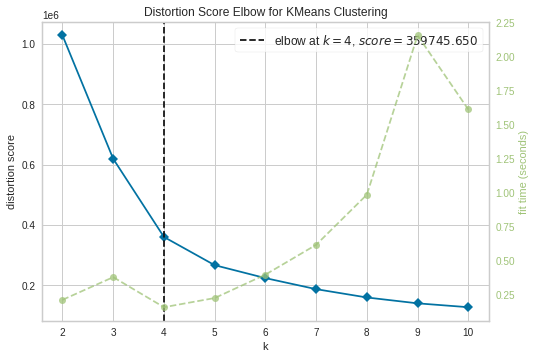

In [8]:
visualizer = KElbowVisualizer(model, k=(2,11), timings= True)
visualizer.fit(df)
visualizer.show()
plt.show()

Según este método la cantidad optima de clusters es de 4

### Silhouette

> El método de la silueta se denomina así porque utiliza el coeficiente de la Silhouette. Éste se define como la diferencia entre la distancia media a los elementos del clúster más cercano y a distancia intra-clúster media de los elementos de un clúster dividido por el máximo de los dos. En el momento que se alcance el número de clústeres óptimos para un conjunto de datos, la Silhouette, en esta situación, se maximiza. 

Pulido, M. (2019, 10 julio). Análisis de datos mediante clustering. SlashMobility | Soluciones mobile. https://slashmobility.com/blog/2019/07/clustering-como-obtener-agrupaciones-inherentes-en-los-datos/

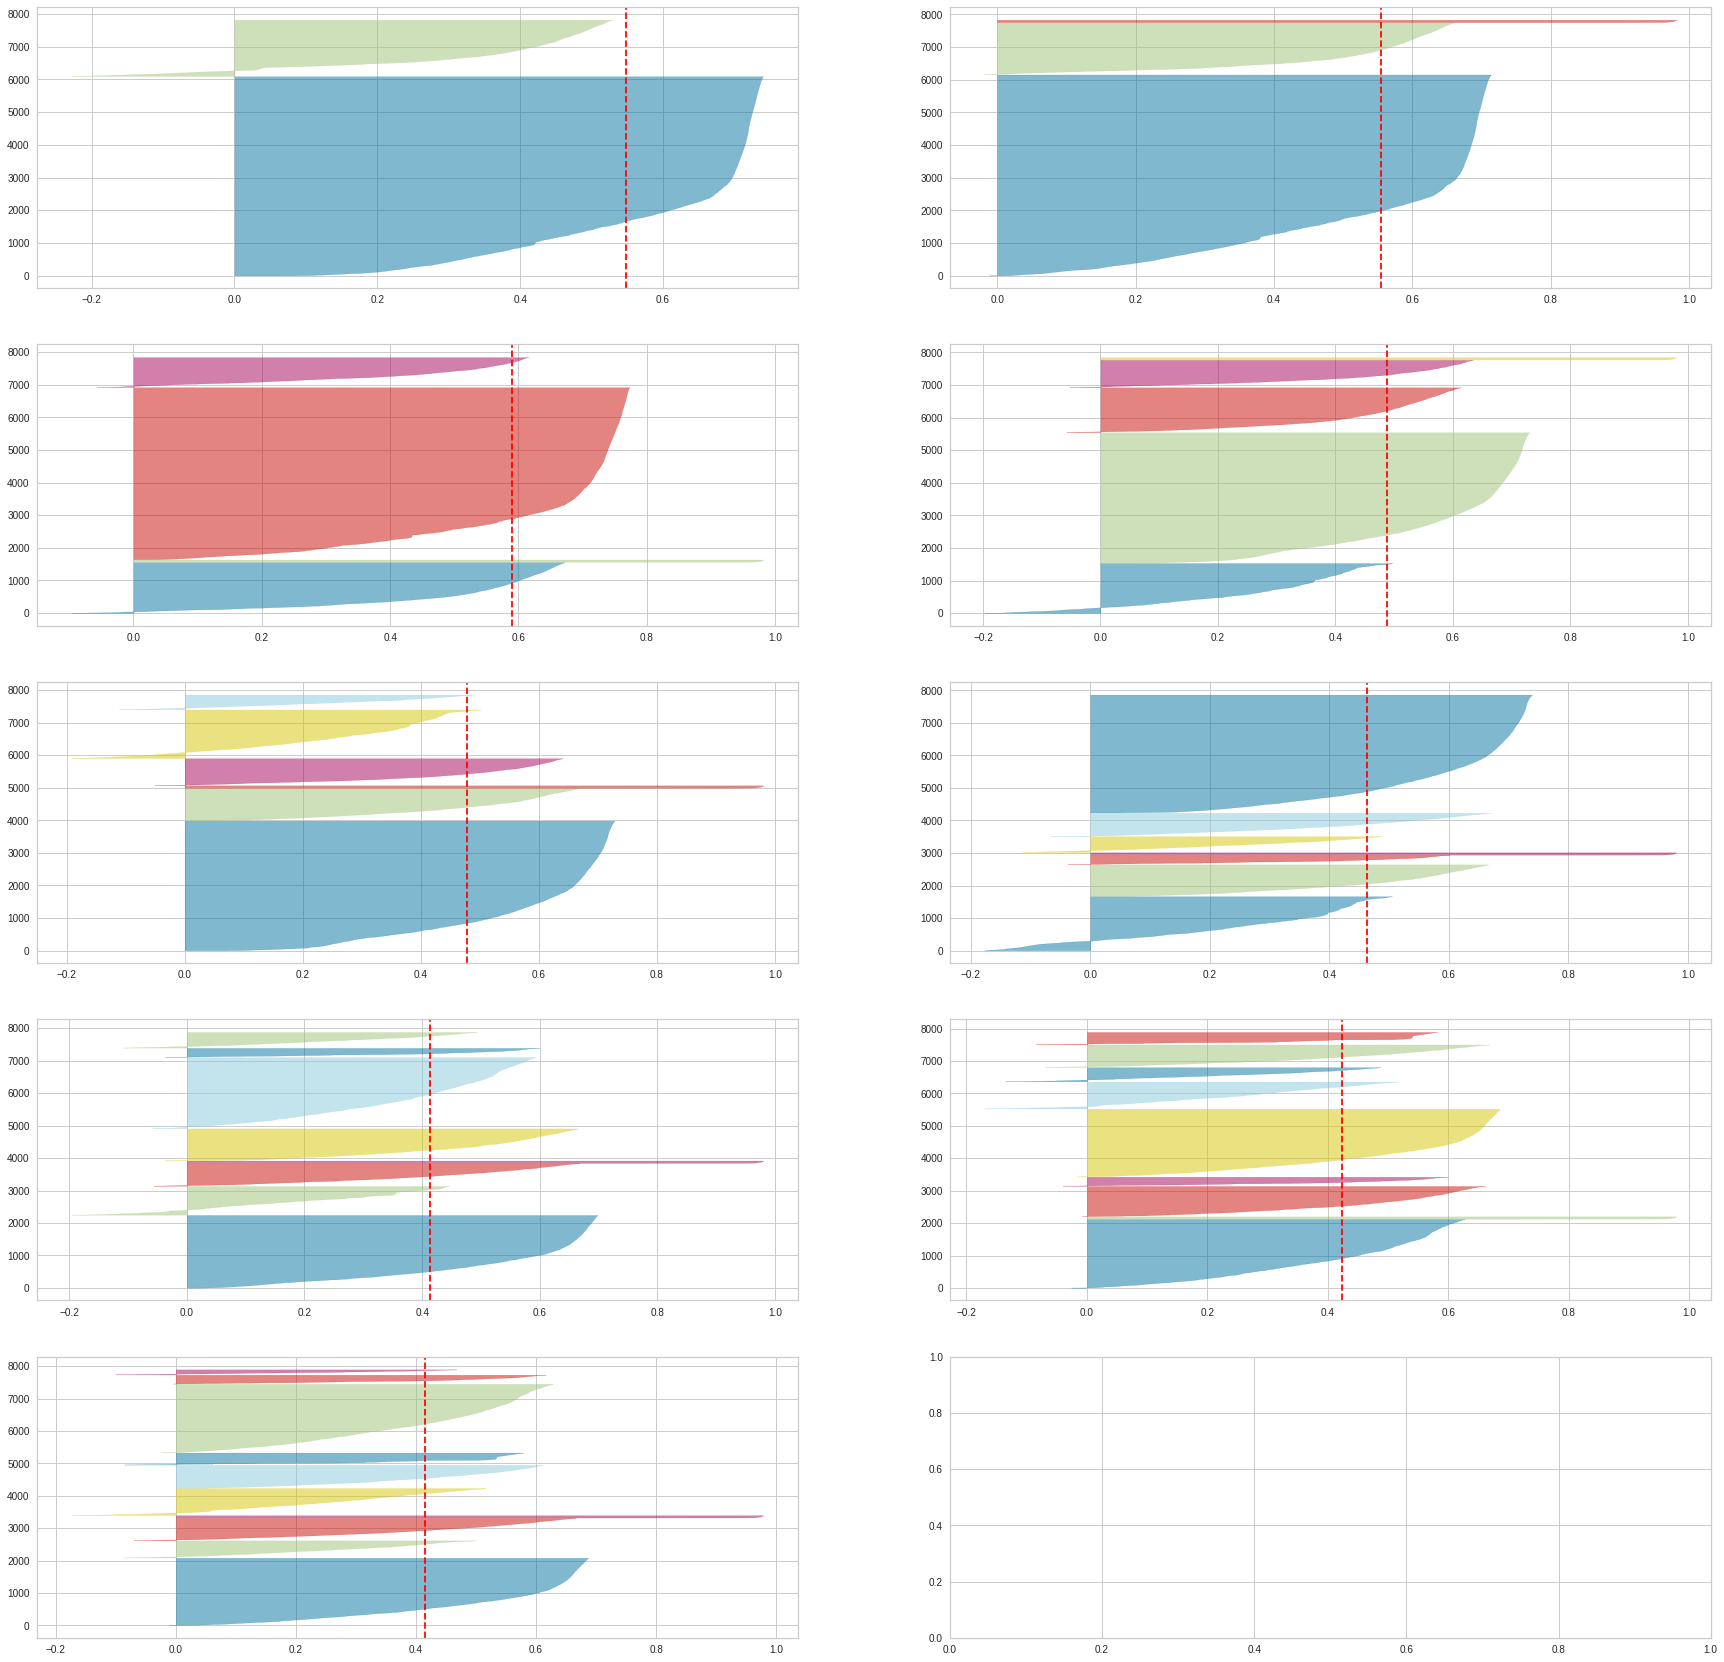

In [9]:
from yellowbrick.cluster import SilhouetteVisualizer
model.fit_predict(df)
#
# Calculate Silhoutte Score
#

fig, ax = plt.subplots(5, 2, figsize=(30,30))
for i in range(2,11):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df)

Según este método y según la decisión conjunta del equipo se decidió escoger una cantidad de grupos de 5.

## Desarrollo del agrupamiento

Se realiza un clustering con el metodo de Kmeans de estas 3 variables generadas, con una cantidad de clusters de 5

In [10]:
km = KMeans(n_clusters=5, random_state=42)
clusters = pd.Series(km.fit_predict(df)+1, name="cluster")
final_df = pd.concat([df, clusters], axis=1)

In [31]:
final_df.sample(n=8)

,0,1,2,cluster
5976,-3.681484,0.045323,-2.451454,2
4492,-6.189689,0.265594,-1.586510,2
664,23.172458,-6.898220,-3.149412,3
4450,-10.369428,0.223835,-1.742675,2
1947,-4.709563,-0.123350,-2.764851,2
7162,-1.788452,1.416779,-3.402280,1
6298,-2.978339,2.832969,-2.059962,2
4996,9.907930,2.990470,-4.190678,1


### Datos por grupos (por color)

In [13]:
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py

# 3d scatterplot using plotly
Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'),zaxis = dict(title  = 'PC3'))

# model.labels_ is nothing but the predicted clusters i.e y_clusters
labels = km.labels_
trace = go.Scatter3d(x=final_df.iloc[:, 0], y=final_df.iloc[:, 1], z=final_df.iloc[:, 2], mode='markers',marker=dict(color = labels, size= 5, line=dict(color= 'black',width = 1)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

Se observan claramente donde están los grupos en el espacio de las variables creadas a partir de otras.

In [14]:
df_source = pd.read_csv('datasets/formatted_data.csv')

In [15]:
group = pd.concat([df_source, final_df], axis=1)
group.sample(n=5)

,UNITID,OPEID,opeid6,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,NPCURL,...,PELL_RPY_3YR_RT_SUPP,NOPELL_RPY_3YR_RT_SUPP,FEMALE_RPY_3YR_RT_SUPP,MALE_RPY_3YR_RT_SUPP,FIRSTGEN_RPY_3YR_RT_SUPP,NOTFIRSTGEN_RPY_3YR_RT_SUPP,0,1,2,cluster
2033,176664.0,1320800.0,13208.0,Baptist Bible College,Springfield,MO,65803-3498,Association for Biblical Higher Education Comm...,www.gobbc.edu,gobbc.edu,...,0.835897,0.835165,0.843284,0.826667,0.810811,0.858974,3.789189,-2.242537,-2.831922,1
1220,151379.0,181700.0,1817.0,Indiana University-Southeast,New Albany,IN,47150,North Central Association of Colleges and Scho...,ius.edu/,www.indianacollegecosts.org/calculate-your-col...,...,0.664269,0.813268,0.732129,0.705656,0.699232,0.750507,18.244727,-6.198680,1.201384,3
6287,454078.0,4152100.0,41521.0,Toledo Restaurant Training Center,Toledo,OH,43606,Council on Occupational Education,www.trtcoh.org,www.trtc.edu,...,NaN,NaN,NaN,NaN,NaN,NaN,-11.217989,0.223224,-1.532449,2
7018,474951.0,32098864.0,20988.0,University of Phoenix-Baton Rouge Campus,Baton Rouge,LA,70808-2300,NaN,www.phoenix.edu,www.phoenix.edu/tuition_and_financial_options/...,...,0.344055,0.582945,0.405373,0.408658,0.401544,0.442693,21.326673,72.497382,8.507578,5
7472,13508103.0,2151904.0,21519.0,Keiser University-Daytona,Daytona Beach,FL,32114,NaN,http://www.keiseruniversity.edu,NaN,...,0.434421,0.582421,0.468705,0.464912,0.458959,0.492395,1.716617,5.743823,-1.158577,1


### Centroides de los clusters

In [16]:
km.cluster_centers_

array([[ 2.36665971,  2.68745416, -1.32526266],
       [-7.15937554,  0.30939681, -1.32038778],
       [15.98818596, -4.95582725, -4.78967562],
       [ 1.83576395, -4.3884968 , 15.88532876],
       [22.59368228, 72.13652138,  8.26673536]])

In [17]:
group.shape

(7804, 555)

In [18]:
group.fillna(group.groupby('cluster').transform('mean'), inplace=True)

In [19]:
from scipy.spatial import distance

In [20]:
coord_reg = ()

min_1 = 1000, None
min_2 = 1000, None
min_3 = 1000, None
min_4 = 1000, None
min_5 = 1000, None

centroid_1 = tuple(km.cluster_centers_[0])
centroid_2 = tuple(km.cluster_centers_[1])
centroid_3 = tuple(km.cluster_centers_[2])
centroid_4 = tuple(km.cluster_centers_[3])
centroid_5 = tuple(km.cluster_centers_[4])

dis_1 = []
dis_2 = []
dis_3 = []
dis_4 = []
dis_5 = []

for index, i in group.iterrows():
  point_reg = (i["0"], i["1"], i["2"])
  distance_1 = distance.euclidean(point_reg, centroid_1)
  distance_2 = distance.euclidean(point_reg, centroid_2)
  distance_3 = distance.euclidean(point_reg, centroid_3)
  distance_4 = distance.euclidean(point_reg, centroid_4)
  distance_5 = distance.euclidean(point_reg, centroid_5)
  dis_1.append(distance_1)
  dis_2.append(distance_2)
  dis_3.append(distance_3)
  dis_4.append(distance_4)
  dis_5.append(distance_5)

  if distance_1 < min_1[0]:
    min_1 = distance_1, i
  if distance_2 < min_2[0]:
    min_2 = distance_2, i
  if distance_3 < min_3[0]:
    min_3 = distance_3, i
  if distance_4 < min_4[0]:
    min_4 = distance_4, i
  if distance_5 < min_5[0]:
    min_5 = distance_5, i
group["Dist_1"] = dis_1
group["Dist_2"] = dis_2
group["Dist_3"] = dis_3
group["Dist_4"] = dis_4
group["Dist_5"] = dis_5

#### Top representantes del grupo 1

In [21]:
group.sort_values("Dist_1", ascending=True).head(5)

,UNITID,OPEID,opeid6,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,NPCURL,...,NOTFIRSTGEN_RPY_3YR_RT_SUPP,0,1,2,cluster,Dist_1,Dist_2,Dist_3,Dist_4,Dist_5
5587,441973.0,2179944.0,21799.0,The Art Institute of California-Argosy Univers...,Santa Ana,CA,92704,NaN,www.aicaoc.artinstitutes.edu,tcc.noellevitz.com/edmc/Freshman-Students?ifra...,...,0.428122,2.110517,3.491957,-1.593056,1,0.885747,9.804792,16.558175,19.174748,72.310800
376,117113.0,2179947.0,21799.0,The Art Institute of California-Argosy Univers...,San Diego,CA,92108-4423,NaN,www.artinstitutes.edu/san-diego/,tcc.noellevitz.com/edmc/Freshman-Students?ifra...,...,0.428122,2.446145,3.503818,-1.818705,1,0.957211,10.135022,16.241279,19.393143,72.236330
5525,440925.0,3031402.0,30314.0,International Academy of Design and Technology...,Orlando,FL,32809,NaN,www.iadt.edu,iadt.studentaidcalculator.com,...,0.423025,2.376508,2.153409,-2.124066,1,0.960931,9.745735,15.586035,19.168392,73.582192
6451,456296.0,3031400.0,30314.0,International Academy of Design and Technology...,Tampa,FL,33634,Accrediting Council for Independent Colleges a...,www.iadt.edu/Online,iadt.studentaidcalculator.com,...,0.423025,2.257965,2.244208,-2.177056,1,0.966350,9.652133,15.722126,19.246318,73.536043
7613,22870501.0,363901.0,3639.0,Texas A&M University-San Antonio,San Antonio,TX,78222,NaN,http://www.tamusa.tamus.edu/,NaN,...,0.670087,1.947053,1.785207,-1.249031,1,0.997964,9.225516,15.972825,18.212997,73.933352


#### Top representantes del grupo 2

In [22]:
group.sort_values("Dist_2", ascending=True).head(5)

,UNITID,OPEID,opeid6,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,NPCURL,...,NOTFIRSTGEN_RPY_3YR_RT_SUPP,0,1,2,cluster,Dist_1,Dist_2,Dist_3,Dist_4,Dist_5
5473,439871.0,3479300.0,34793.0,PCI College,Cerritos,CA,90703,Accrediting Commission of Career Schools and C...,www.pci-ed.com,www.pci-ed.com/financialaid.html,...,0.403846,-7.091114,0.253809,-1.329571,2,9.765866,0.088509,23.911644,19.939733,78.360708
2539,193265.0,2275900.0,22759.0,Modern Welding School,Schenectady,NY,12304,Accrediting Commission of Career Schools and C...,www.modernwelding.com,www.modernwelding.com/Net%20Price%20Calculator...,...,0.777778,-7.274926,0.299071,-1.175843,2,9.934127,0.185342,24.121487,19.901296,78.370373
6325,454731.0,4133000.0,41330.0,BioHealth College,San Jose,CA,95134,Accrediting Council for Continuing Education a...,www.biohealthcollege.edu,biohealthcollege.edu,...,0.673913,-7.270076,0.305036,-1.108962,2,9.929218,0.238693,24.128221,19.843172,78.355025
3492,217794.0,2356600.0,23566.0,Charleston Cosmetology Institute,Charleston,SC,29420,Council on Occupational Education,www.charlestoncosmetology.com,www.charlestoncosmetology.com/netpricecalculat...,...,0.594937,-7.310251,0.432873,-1.473163,2,9.937184,0.247690,24.142380,20.204268,78.297663
6322,454698.0,4115600.0,41156.0,Mayfield College,Cathedral City,CA,92234,Council on Occupational Education,www.mayfieldcollege.edu,mayfieldcollege.edu/Student%20Consumer%20Infor...,...,0.400000,-7.433667,0.338144,-1.215893,2,10.078572,0.294926,24.277175,20.017873,78.400057


#### Top representantes del grupo 3

In [23]:
group.sort_values("Dist_3", ascending=True).head(3)

,UNITID,OPEID,opeid6,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,NPCURL,...,NOTFIRSTGEN_RPY_3YR_RT_SUPP,0,1,2,cluster,Dist_1,Dist_2,Dist_3,Dist_4,Dist_5
1364,155025.0,192700.0,1927.0,Emporia State University,Emporia,KS,66801-5087,North Central Association of Colleges and Scho...,www.emporia.edu,collegeportraits.org/KS/ESU/estimator/agree,...,0.844844,15.994665,-4.896633,-4.801421,3,15.978879,23.986036,0.060695,25.073378,78.411929
2312,185828.0,262100.0,2621.0,New Jersey Institute of Technology,Newark,NJ,7102,Middle States Commission on Higher Education,www.njit.edu/,www.njit.edu/admissions/njheoa/,...,0.892060,15.615284,-4.978223,-4.909458,3,15.720532,23.654291,0.392308,24.952878,78.542943
1559,161165.0,204300.0,2043.0,Husson University,Bangor,ME,04401-2999,New England Association of Schools and College...,www.husson.edu,npc.collegeboard.org/student/app/husson,...,0.774757,15.634812,-5.006471,-4.483839,3,15.659404,23.618654,0.470079,24.610945,78.498689


#### Top representantes del grupo 4

In [24]:
group.sort_values("Dist_4", ascending=True).head(3)

,UNITID,OPEID,opeid6,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,NPCURL,...,NOTFIRSTGEN_RPY_3YR_RT_SUPP,0,1,2,cluster,Dist_1,Dist_2,Dist_3,Dist_4,Dist_5
1899,173115.0,575900.0,5759.0,Northwest Technical College,Bemidji,MN,56601-4907,North Central Association of Colleges and Scho...,www.ntcmn.edu,www.mnscu.edu/admissions/calculator/northwest....,...,0.654506,1.827025,-4.365469,15.981810,4,18.696783,20.049335,25.146404,0.099576,79.645031
4173,239008.0,919400.0,9194.0,Lakeshore Technical College,Cleveland,WI,53015-1414,North Central Association of Colleges and Scho...,www.gotoltc.edu,gotoltc.edu/calculator/npcalc.htm,...,0.805970,1.236542,-4.182551,15.731385,4,18.422903,19.530283,25.284835,0.652058,79.601816
3769,226204.0,358300.0,3583.0,Lee College,Baytown,TX,77520,Southern Association of Colleges and Schools C...,www.lee.edu,www.lee.edu/financialaid/,...,0.503012,1.280567,-4.636165,16.197396,4,19.022580,20.063996,25.629541,0.683351,80.069904


#### Top representantes del grupo 5

In [25]:
group.sort_values("Dist_5", ascending=True).head(5)

,UNITID,OPEID,opeid6,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,NPCURL,...,NOTFIRSTGEN_RPY_3YR_RT_SUPP,0,1,2,cluster,Dist_1,Dist_2,Dist_3,Dist_4,Dist_5
5415,438416.0,32098883.0,20988.0,University of Phoenix-West Michigan Campus,Walker,MI,49544-1683,NaN,www.phoenix.edu,www.phoenix.edu/tuition_and_financial_options/...,...,0.442693,22.605013,71.962538,8.259416,5,72.804493,78.178412,78.297485,79.492117,0.174506
5414,438382.0,32098806.0,20988.0,University of Phoenix-Southern Colorado Campus,Colorado Springs,CO,80919-2221,NaN,www.phoenix.edu,www.phoenix.edu/tuition_and_financial_options/...,...,0.442693,22.579446,71.961902,8.205182,5,72.789665,78.161471,78.285683,79.490053,0.185697
5695,443890.0,42098869.0,20988.0,University of Phoenix-Memphis Campus,Cordova,TN,38018-7290,NaN,www.phoenix.edu,www.phoenix.edu/tuition_and_financial_options/...,...,0.442693,22.594253,72.276453,8.071333,5,73.075853,78.439403,78.573983,79.809072,0.240340
5351,434991.0,52098869.0,20988.0,University of Phoenix-Tulsa Campus,Tulsa,OK,74134-1412,NaN,www.phoenix.edu,www.phoenix.edu/tuition_and_financial_options/...,...,0.442693,22.623593,72.458121,8.379903,5,73.297200,78.654684,78.806001,79.961666,0.342240
5882,446738.0,42098878.0,20988.0,University of Phoenix-San Antonio Campus,San Antonio,TX,78230-3876,NaN,www.phoenix.edu,www.phoenix.edu/tuition_and_financial_options/...,...,0.442693,22.607589,72.360603,8.005263,5,73.151224,78.513796,78.647042,79.899865,0.344635


In [26]:
group.head()

,UNITID,OPEID,opeid6,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,NPCURL,...,NOTFIRSTGEN_RPY_3YR_RT_SUPP,0,1,2,cluster,Dist_1,Dist_2,Dist_3,Dist_4,Dist_5
0,100654.0,100200.0,1002.0,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,galileo.aamu.edu/netpricecalculator/npcalc.htm,...,0.442453,13.373817,-3.675245,-4.566452,3,13.120472,21.166632,2.919699,23.492781,77.441078
1,100663.0,105200.0,1052.0,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,www.uab.edu,www.collegeportraits.org/AL/UAB/estimator/agree,...,0.765075,22.881187,-8.245285,5.349406,3,24.185157,31.939069,12.693895,23.849326,80.435243
2,100690.0,2503400.0,25034.0,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,www.amridgeuniversity.edu,tcc.noellevitz.com/(S(miwoihs5stz5cpyifh4nczu0...,...,0.650000,-0.448998,-1.009246,-2.730411,1,4.854685,6.982560,17.029301,19.057419,77.473903
3,100706.0,105500.0,1055.0,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu,finaid.uah.edu/,...,0.791667,17.936838,-4.945177,-5.252279,3,17.779454,25.940128,2.002838,26.577301,78.396672
4,100724.0,100500.0,1005.0,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/email/index.aspx,www.alasu.edu/cost-aid/forms/calculator/index....,...,0.334633,10.845148,-2.507392,-4.656914,3,10.486710,18.526456,5.697658,22.509805,76.660045


## Categorización de clusters

Antes de comenzar es importante aclarar las explicaciones que se le dieron a cada componente principal:

**PC1:**  Componente relacionada con el puntaje Carnegie y las tasas de reembolso de la institución.

**PC2:** Componente relacionada con la cantidad de estudiantes independientes que tienen una deuda media y el numero de estudiantes con bajos ingresos.

**PC3:** Componente relacionada con los certificados obtenidos por la institución

In [27]:
# 3d scatterplot using plotly
Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'),zaxis = dict(title  = 'PC3'))

# model.labels_ is nothing but the predicted clusters i.e y_clusters
labels = [1,2,3,4,5]
trace = go.Scatter3d(x=group.loc[[5587,5473,1364,1899,5415], "0"], y=group.loc[[5587,5473,1364,1899,5415], "1"], z=group.loc[[5587,5473,1364,1899,5415], "2"], mode='markers',marker=dict(color = labels, size= 5, line=dict(color= 'black',width = 1)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

**Cluster amarillo**: Las instituciones que estan en este cluster presentan las calificaciones mas altas en el puntaje carnegie y tienen el mayor numero de estudiantes con una deudas medias y de bajos ingresos. 

**Cluster naranja**: Las instituciones que estan en este cluster presentan en su mayoria una gran cantidad de certificados en ingenierias y artes.

**Cluster rojo**: Las instituciones que estan en este cluster tienen la cantidad de certificaciones mas baja de todas y tienen pocos estudiandes que tengan deudas medias y bajos ingresos.

**Cluster morado**: Las instituciones que estan en este cluster suelen tener malas calificaciones en el puntaje carnegie y su cantidad de certificaciones es baja.

**Cluster azul**: Las instituciones que estan en este cluster tienen pocos certificados en ingenieria y artes, pero cuentan con una calificación media en el puntaje carnegie y tienen un numero medio de estudiantes con deudas y de bajos ingresos.

In [28]:
# 3d scatterplot using plotly
Scene = dict(xaxis = dict(title  = 'CCSIZSET'),yaxis = dict(title  = 'IND_DEBT_N'),zaxis = dict(title  = 'CIP15CERT2'))

# model.labels_ is nothing but the predicted clusters i.e y_clusters
labels = km.labels_
trace = go.Scatter3d(x=group.loc[:, "CCSIZSET"], y=group.loc[:, "IND_DEBT_N"], z=group.loc[:, "CIP15CERT2"], mode='markers',marker=dict(color = labels, size= 5, line=dict(color= 'black',width = 1)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()